# Exploratory Data Analysis (EDA) — NBA Awards Prediction

This notebook is dedicated to an **in-depth exploratory analysis** of the final NBA players dataset.

At this stage of the project:
- All **data fetching** has been completed
- All **data building and enrichment** steps have been validated
- A **single, consolidated dataset** is now available for analysis

The goal of this notebook is to:
- Understand the structure and coverage of the dataset
- Evaluate the relevance and quality of available metrics
- Identify which features should be **kept, transformed, or discarded**
- Prepare the ground for **predictive modeling** of NBA awards (MVP, DPOY, ROTY, etc.)

This notebook focuses exclusively on **understanding the data**, not on modeling yet.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

## Dataset loading

We load the **final enriched players dataset**, which aggregates:

- Basketball-Reference regular season statistics
- Percentile-based statistics
- Biographical information (NBA API)
- Advanced metrics:
  - MAMBA
  - LEBRON
  - RAPTOR

Each row corresponds to **one player-season**, covering seasons from **1996 to 2024**.

All entity resolution (player matching), season alignment, and metric validation
have already been handled upstream in the BUILD pipeline.


In [2]:
from pathlib import Path

# Notebook-safe project root detection
PROJECT_ROOT = Path.cwd()

# On remonte tant qu'on voit "notebooks" dans le chemin
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data/processed/players/final/all_years_enriched.parquet"

print("Resolved DATA_PATH:", DATA_PATH)
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"


Resolved DATA_PATH: C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\processed\players\final\all_years_enriched.parquet


## First overview of the dataset

At this point, we perform a first sanity check:

- Number of rows → total player-seasons
- Number of columns → total available features
- Column names → raw view of the feature space

This quick inspection helps confirm that:
- The dataset was loaded correctly
- All expected metric families are present
- No obvious structural issue exists before deeper analysis

In [3]:
df = pd.read_parquet(DATA_PATH)
df.shape, df.columns.tolist()

((14412, 436),
 ['Rk',
  'Player',
  'Age',
  'Team',
  'Pos',
  'G',
  'GS',
  'MP',
  'FG',
  'FGA',
  'FG%',
  '3P',
  '3PA',
  '3P%',
  '2P',
  '2PA',
  '2P%',
  'eFG%',
  'FT',
  'FTA',
  'FT%',
  'ORB',
  'DRB',
  'TRB',
  'AST',
  'STL',
  'BLK',
  'TOV',
  'PF',
  'PTS',
  'season',
  'tot_Rk',
  'tot_Age',
  'tot_Pos',
  'tot_G',
  'tot_GS',
  'tot_MP',
  'tot_FG',
  'tot_FGA',
  'tot_FG%',
  'tot_3P',
  'tot_3PA',
  'tot_3P%',
  'tot_2P',
  'tot_2PA',
  'tot_2P%',
  'tot_eFG%',
  'tot_FT',
  'tot_FTA',
  'tot_FT%',
  'tot_ORB',
  'tot_DRB',
  'tot_TRB',
  'tot_AST',
  'tot_STL',
  'tot_BLK',
  'tot_TOV',
  'tot_PF',
  'tot_PTS',
  'tot_Trp-Dbl',
  'tot_Awards',
  'p36_Rk',
  'p36_Age',
  'p36_Pos',
  'p36_G',
  'p36_GS',
  'p36_MP',
  'p36_FG',
  'p36_FGA',
  'p36_FG%',
  'p36_3P',
  'p36_3PA',
  'p36_3P%',
  'p36_2P',
  'p36_2PA',
  'p36_2P%',
  'p36_eFG%',
  'p36_FT',
  'p36_FTA',
  'p36_FT%',
  'p36_ORB',
  'p36_DRB',
  'p36_TRB',
  'p36_AST',
  'p36_STL',
  'p36_BLK',
  '

In [4]:
print("rows:", len(df))
print("season min/max:", df["season"].min(), df["season"].max())
print("n seasons:", df["season"].nunique())
print("seasons tail:", sorted(df["season"].unique())[-5:])

rows: 14412
season min/max: 1996 2025
n seasons: 30
seasons tail: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## Dataset overview

We briefly inspect the dataset to confirm its structure, content, and consistency.
Each row represents a player-season with both raw statistics and advanced metrics.


In [5]:
df.head()
df.sample(5)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season,tot_Rk,tot_Age,tot_Pos,tot_G,tot_GS,tot_MP,tot_FG,tot_FGA,tot_FG%,tot_3P,tot_3PA,tot_3P%,tot_2P,tot_2PA,tot_2P%,tot_eFG%,tot_FT,tot_FTA,tot_FT%,tot_ORB,tot_DRB,tot_TRB,tot_AST,tot_STL,tot_BLK,tot_TOV,tot_PF,tot_PTS,tot_Trp-Dbl,tot_Awards,p36_Rk,p36_Age,p36_Pos,p36_G,p36_GS,p36_MP,p36_FG,p36_FGA,p36_FG%,p36_3P,p36_3PA,p36_3P%,p36_2P,p36_2PA,p36_2P%,p36_eFG%,p36_FT,p36_FTA,p36_FT%,p36_ORB,p36_DRB,p36_TRB,p36_AST,p36_STL,p36_BLK,p36_TOV,p36_PF,p36_PTS,p36_Awards,p100_Rk,p100_Age,p100_Pos,p100_G,p100_GS,p100_MP,p100_FG,p100_FGA,p100_FG%,p100_3P,...,pct_adv_BPM,pct_adv_VORP,pct_adj_FG%,pct_adj_2P%,pct_adj_3P%,pct_adj_eFG%,pct_adj_FT%,pct_adj_TS%,pct_is_mvp_winner,pct_is_dpoy_winner,pct_is_roy_winner,pct_is_mip_winner,pct_is_smoy_winner,pct_is_cpoy_winner,shot_Rk,shot_Age,shot_Pos,shot_G,shot_GS,shot_MP,shot_FG%,shot_Dist.,shot_2P,shot_0-3,shot_3-10,shot_10-16,shot_16-3P,shot_3P,shot_2P__2,shot_0-3__2,shot_3-10__2,shot_10-16__2,shot_16-3P__2,shot_3P__2,shot_2P__3,shot_3P__3,shot_%FGA,shot_#,shot_%3PA,shot_3P%,shot_Att.,shot_Md.,shot_Awards,pct_shot_FG%,pct_shot_3P%,player_key,player_name_raw,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,AST_PCT,PLAYER_HEIGHT_IN,year,mamba__D-MAMBA,mamba__D-MAMBA_rank,mamba__MAMBA,mamba__MAMBA_rank,mamba__Minutes,mamba__O-MAMBA,mamba__O-MAMBA_rank,mamba__nba_id,mamba__player_name,lebron__D-LEBRON,lebron__D_LEBRON_Rank,lebron__LEBRON,lebron__LEBRON_Rank,lebron__Minutes,lebron__O-LEBRON,lebron__O_LEBRON_Rank,lebron__Season,lebron__nba_id,lebron__player_name,raptor__d_raptor_rank,raptor__mp,raptor__nba_id,raptor__o_raptor_rank,raptor__player_id,raptor__player_name,raptor__poss,raptor__raptor_defense,raptor__raptor_offense,raptor__raptor_rank,raptor__raptor_total,raptor__season,raptor__war_total
7514,279.0,Samardo Samuels,23.0,CLE,C,54.0,0.0,15.3,1.9,4.3,0.00455,0.0,0.0,NaN,1.9,4.3,0.00455,0.00455,1.5,2.2,0.00701,1.2,2.2,3.3,0.4,0.4,0.4,1.0,2.1,5.4,2012,244.0,23.0,C,54.0,0.0,825.0,105.0,231.0,0.00455,0.0,0.0,NaN,105.0,231.0,0.00455,0.00455,82.0,117.0,0.00701,63.0,117.0,180.0,20.0,20.0,20.0,56.0,113.0,292.0,0.0,None,258.0,23.0,C,54.0,0.0,825.0,4.6,10.1,0.00455,0.0,0.0,NaN,4.6,10.1,0.00455,0.00455,3.6,5.1,0.00701,2.7,5.1,7.9,0.9,0.9,0.9,2.4,4.9,12.7,None,258.0,23.0,C,54.0,0.0,825.0,6.7,14.7,0.00455,0.0,...,0.114017,0.018828,0.664927,0.462422,NaN,0.354906,0.379310,0.531315,0.5,0.5,0.5,0.5,0.5,0.501044,258.0,23.0,C,54.0,0.0,825.0,0.00455,6.9,1.0,0.485,0.221,0.087,0.208,0.0,0.455,0.616,0.196,0.45,0.354,None,0.581,None,0.113,23.0,None,NaN,0.0,0.0,None,0.664927,NaN,samardo samuels,Samardo Samuels,202396.0,Samardo Samuels,1.610613e+09,CLE,22.0,6-9,81.0,260.0,Louisville,Jamaica,Undrafted,Undrafted,Undrafted,-9.4,0.102,0.129,0.211,0.498,0.043,81.0,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1.21,68.5,-1.70,362.0,825.0,-2.91,460.0,2011-12,202396.0,samardo samuels,126.0,825.0,202396,284.0,samuesa01,Samardo Samuels,1587.0,0.1,-4.4,277.0,-4.2,2012.0,-0.619179
13769,338.0,Seth Curry,33.0,2TM,SG,44.0,4.0,14.0,1.8,4.6,0.00392,0.9,2.5,0.00352,1.0,2.2,0.00438,0.00485,0.6,0.7,0.00903,0.4,1.1,1.5,1.0,0.5,0.1,0.5,0.9,5.1,2024,326.0,33.0,SG,44.0,4.0,616.0,80.0,204.0,0.00392,38.0,108.0,0.00352,42.0,96.0,0.00438,0.00485,28.0,31.0,0.00903,18.0,50.0,68.0,44.0,22.0,6.0,21.0,39.0,226.0,0.0,None,332.0,33.0,SG,44.0,4.0,616.0,4.7,11.9,0.00392,2.2,6.3,0.00352,2.5,5.6,0.00438,0.00485,1.6,1.8,0.00903,1.1,2.9,4.0,2.6,1.3,0.4,1.2,2.3,13.2,None,332.0,33.0,SG,44.0,4.0,616.0,6.3,16.0,0.00392,3.0,...,0.284091,0.175699,0.185413,0.127641,0.526802,0.235501,0.908922,0.255712,0.5,0.5,0.5,0.5,0.5,0.500000,332.0,33.0,SG,44.0,4.0,616.0,0.00392,19.5,0.471,0.059,0.103,0.074,0.235,0.529,0.438,0.833,0.524,0.133,0.396,0.352,0.5,0.868,0.0,0.0,0.324,0.00457,1.0,0.0,None,0.185413,0.795229,seth

## Descriptive statistics

We compute basic summary statistics for all numerical features to get a global view
of their scale, distribution, and potential anomalies.


In [6]:
df.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
Rk,14412.0,243.132459,143.084134,1.0,121.0,241.0,361.0,605.0
Age,14412.0,26.559603,4.318329,18.0,23.0,26.0,29.0,44.0
G,14412.0,50.904246,25.125973,1.0,31.0,57.0,73.0,85.0
GS,14412.0,24.63572,28.416145,0.0,1.0,10.0,49.0,83.0
MP,14412.0,20.152651,9.986315,0.0,12.0,19.5,28.4,43.7
...,...,...,...,...,...,...,...,...
raptor__raptor_offense,7570.0,-0.197754,2.232731,-8.3,-1.7,-0.3,1.1,10.4
raptor__raptor_rank,7570.0,149.62391,86.841367,1.0,75.0,149.0,223.0,331.0
raptor__raptor_total,7570.0,-0.201361,2.78506,-10.0,-2.1,-0.3,1.5,12.6
raptor__season,7570.0,2009.322325,7.835047,1996.0,2003.0,2009.0,2016.0,2022.0


## Player coverage over time

We visualize the number of players per season to verify temporal coverage
and ensure dataset consistency across years.


Text(0.5, 1.0, 'Number of players per season')

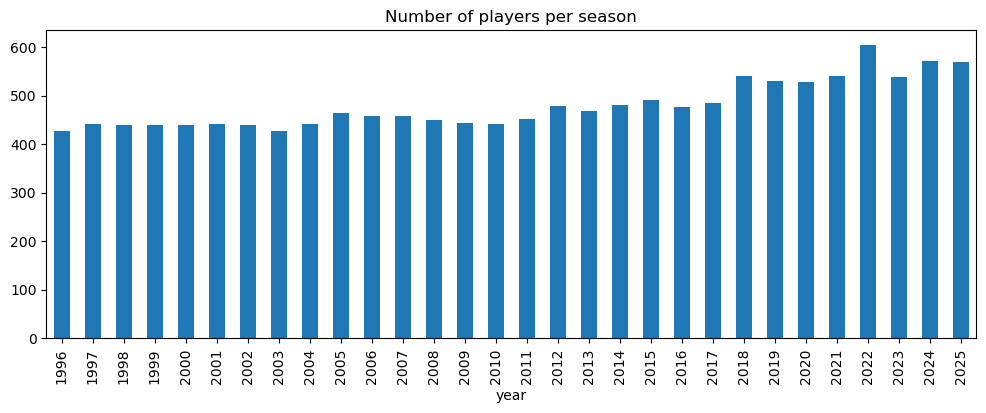

In [7]:
df["year"].value_counts().sort_index().plot(kind="bar", figsize=(12,4))
plt.title("Number of players per season")

### 🏆 Major Individual Awards (MVP, DPOY, 6MOY)

This cell identifies the winners of major NBA awards by automatically selecting the most reliable signal  
(rank, vote share, or points won) for each season.

The focus is on awards that reflect season-level impact and are relevant for performance-based modeling.


In [8]:
season_col = "season" if "season" in df.columns else "year"
player_col = "Player" if "Player" in df.columns else "player_fixed"

def winner_counts_rank(key: str, top=15):
    col = f"{key}_rank"
    if col not in df.columns:
        print(f"\n🏆 {key.upper()} – column not found ({col})")
        return

    tmp = df[[season_col, player_col, col]].copy()
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce")

    winners = (
        tmp[tmp[col] == 1]
        .groupby(player_col)[season_col]
        .nunique()
        .sort_values(ascending=False)
        .head(top)
    )

    print(f"\n🏆 {key.upper()} – Most winners (rank == 1)")
    display(winners)

# Major awards + 6MOY all use *_rank
for key in ["mvp", "dpoy", "smoy"]:
    winner_counts_rank(key)



🏆 MVP – Most winners (rank == 1)


Player
LeBron James             4
Nikola JokiA             3
Karl Malone              2
Stephen Curry            2
Steve Nash               2
Michael Jordan           2
Giannis Antetokounmpo    2
Tim Duncan               2
Dirk Nowitzki            1
Allen Iverson            1
Derrick Rose             1
Kobe Bryant              1
Kevin Garnett            1
Kevin Durant             1
Joel Embiid              1
Name: season, dtype: int64


🏆 DPOY – Most winners (rank == 1)


Player
Ben Wallace              4
Rudy Gobert              4
Dwight Howard            3
Dikembe Mutombo          3
Alonzo Mourning          2
Kawhi Leonard            2
Gary Payton              1
Giannis Antetokounmpo    1
Draymond Green           1
Evan Mobley              1
Joakim Noah              1
Jaren Jackson Jr.        1
Marc Gasol               1
Kevin Garnett            1
Marcus Camby             1
Name: season, dtype: int64


🏆 SMOY – Most winners (rank == 1)


Player
Jamal Crawford        3
Lou Williams          3
Antawn Jamison        1
Ben Gordon            1
Corliss Williamson    1
Bobby Jackson         1
Danny Manning         1
Darrell Armstrong     1
Eric Gordon           1
Aaron McKie           1
J.R. Smith            1
James Harden          1
John Starks           1
Jason Terry           1
Jordan Clarkson       1
Name: season, dtype: int64

### 🏅 All-NBA and All-Defense Selections

This cell counts total All-NBA and All-Defense selections per player.

These distinctions capture long-term recognition and career consistency, and will later serve as useful signals for modeling.


In [9]:
player_col = "Player" if "Player" in df.columns else "player_fixed"

selection_cols = {
    "All-NBA": "all_nba_team",
    "All-Defense": "all_def_team",
}

for label, col in selection_cols.items():
    if col not in df.columns:
        print(f"\n🏅 {label} – colonne manquante: {col}")
        continue

    top = (
        df[df[col].notna()]
        .groupby(player_col)[col]
        .count()
        .sort_values(ascending=False)
        .head(15)
    )

    print(f"\n🏅 {label} – Most selections")
    display(top)



🏅 All-NBA – Most selections


Player
LeBron James             21
Kobe Bryant              15
Tim Duncan               15
Shaquille O'Neal         12
Dirk Nowitzki            12
Chris Paul               11
Stephen Curry            11
Kevin Durant             11
Kevin Garnett             9
Russell Westbrook         9
Giannis Antetokounmpo     9
Dwyane Wade               8
Dwight Howard             8
James Harden              8
Damian Lillard            7
Name: all_nba_team, dtype: Int64


🏅 All-Defense – Most selections


Player
Tim Duncan               15
Kobe Bryant              12
Kevin Garnett            12
Jason Kidd                9
Chris Paul                9
Draymond Green            9
Bruce Bowen               8
Rudy Gobert               8
Gary Payton               7
Kawhi Leonard             7
Jrue Holiday              6
Ben Wallace               6
LeBron James              6
Tony Allen                6
Giannis Antetokounmpo     5
Name: all_def_team, dtype: Int64

## 📊 Correlation Analysis – MVP-Related Features

This cell computes a correlation matrix between key performance metrics commonly associated with MVP voting (advanced metrics, box-score stats, usage, and minutes played).

The goal is to analyze linear relationships between these features and the MVP outcome proxy (mvp_rank), in order to understand which variables tend to move together and which may be informative for later modeling.

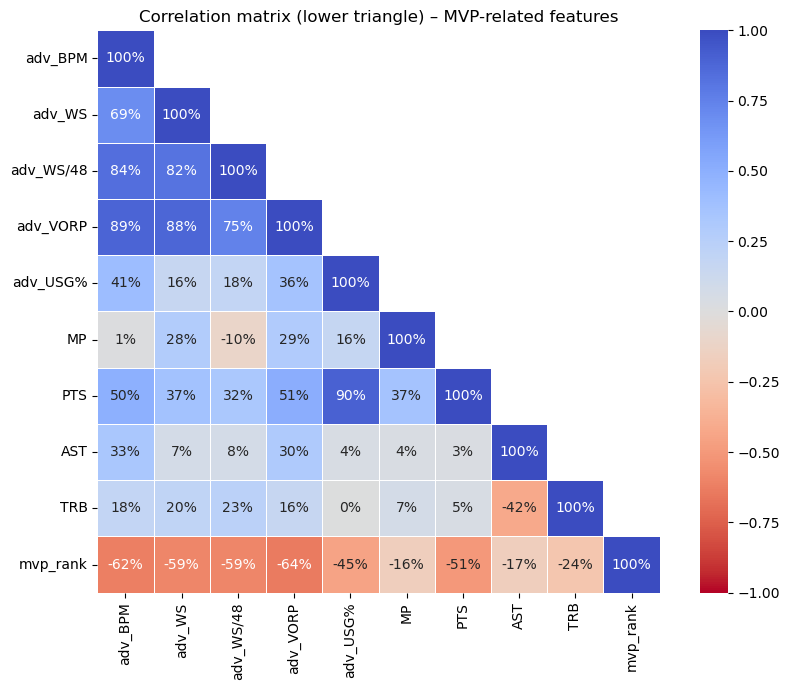

In [10]:
cols = [
    "adv_BPM",
    "adv_WS",
    "adv_WS/48",
    "adv_VORP",
    "adv_USG%",
    "MP",
    "PTS",
    "AST",
    "TRB",
    "mvp_rank",
]

# keep only existing columns
cols = [c for c in cols if c in df.columns]

corr = df[cols].dropna().corr()

# mask upper triangle (keep lower triangle)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm_r",      # inverted color scale
    center=0,
    vmin=-1, vmax=1,
    annot=True,             # show values
    fmt=".0%",              # show as percentage (e.g., 62%)
    linewidths=0.5,
    square=True
)

plt.title("Correlation matrix (lower triangle) – MVP-related features")
plt.tight_layout()
plt.show()


### 📊 Correlation Analysis – MVP-Related Features

Lower `mvp_rank` values indicate better MVP outcomes (with rank = 1 corresponding to the winner).
As a result, **negative correlations with `mvp_rank` should be interpreted as positive MVP signals**.

**Advanced impact metrics** exhibit the strongest relationships with MVP outcomes:
- `adv_VORP`, `adv_BPM`, `adv_WS`, and `adv_WS/48` all show large negative correlations with `mvp_rank`.
- This indicates that MVP voting strongly favors players with high overall on-court impact, as captured by advanced, all-in-one metrics rather than single box-score contributions.

**Scoring volume** (`PTS`) is the most influential traditional statistic:
- It correlates more strongly with MVP rank than assists (`AST`) or rebounds (`TRB`),
- suggesting that offensive responsibility and scoring output remain central to MVP narratives.

**Usage rate (`USG%`)** also shows a meaningful negative correlation with `mvp_rank`:
- High-usage players tend to receive more MVP consideration, likely reflecting offensive leadership and centrality within their teams.

**Minutes played (`MP`)** display only weak correlation:
- MVP recognition is not driven by availability alone, but by *how effective players are while on the court*.

Finally, **strong inter-correlations among advanced metrics** (e.g., BPM, VORP, WS, WS/48):
- highlight substantial redundancy in these features,
- which is important to account for in downstream modeling to avoid multicollinearity and over-weighting similar signals.

Overall, this correlation structure confirms that **MVP voting is primarily driven by holistic impact and offensive prominence**, with advanced metrics serving as the most informative predictors compared to isolated box-score statistics.

### 📊 MVP Consideration vs Scoring

This cell compares **points per game (PTS)** between players who received **MVP consideration**
(players with a non-null `mvp_rank`) and those who did not.

The goal is to assess whether **scoring volume alone** separates MVP-level candidates
from the rest of the league.


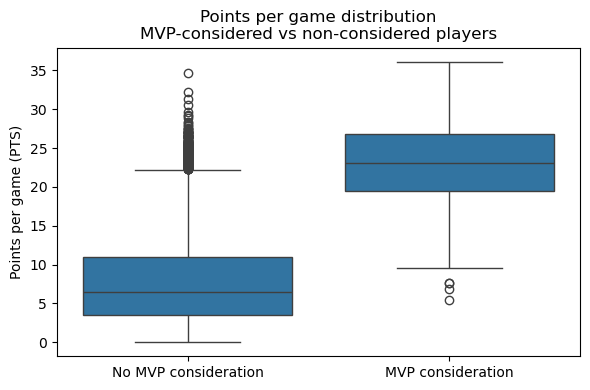

In [11]:
# Binary flag: player received MVP consideration (ranked)
df["has_mvp_consideration"] = df["mvp_rank"].notna()

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="has_mvp_consideration",
    y="PTS"
)

plt.xticks([0, 1], ["No MVP consideration", "MVP consideration"])
plt.title("Points per game distribution\nMVP-considered vs non-considered players")
plt.xlabel("")
plt.ylabel("Points per game (PTS)")
plt.tight_layout()
plt.show()


### 📈 Interpretation of the Result

Players with MVP consideration score **significantly more points per game** than non-considered players.

Key observations:
- The median PTS is much higher for MVP-considered players.
- High scorers exist outside MVP consideration, but they appear mainly as outliers.
- Scoring is a **necessary but not sufficient** condition for MVP candidacy.

This highlights that MVP selection depends not only on scoring,
but also on overall impact, efficiency, and advanced performance metrics.


### 🧑‍🎓 Rookie Profile Analysis

This cell focuses on **rookie players only** and summarizes their
scoring, usage, and playing time distribution.

The goal is to understand the typical statistical profile of rookies,
which is essential for downstream modeling (e.g. ROY prediction or
rookie-specific normalization).


In [12]:
# Filter rookies (correct column name)
df_rookie = df[df["is_rookie"] == 1]

# Descriptive stats for key usage / scoring variables
df_rookie[["PTS", "adv_USG%", "MP"]].describe()


,PTS,adv_USG%,MP
count,2423.000000,2420.000000,2423.000000
mean,4.798102,0.183312,13.418943
std,3.857320,0.059422,8.353641
min,0.000000,0.000000,0.000000
25%,2.000000,0.149000,6.850000
50%,3.800000,0.178000,11.600000
75%,6.400000,0.213000,18.600000
max,23.500000,0.725000,43.500000


### 📊 Rookie Statistical Profile (Regular Season)

This table summarizes the **scoring, usage, and playing time** distribution for rookie players.

Key observations:
- Rookies generally have **limited offensive responsibility**, with a median usage rate around **18%**.
- Scoring output is modest: the median rookie scores **~3.8 PTS per game**, reflecting bench or role-player usage.
- Playing time is highly heterogeneous: while the median is ~11.6 minutes per game, some rookies reach **starter-level minutes** (>40 MPG), indicating early trust or exceptional talent.

Overall, this highlights the strong imbalance among rookies: most have a marginal role, while a small subset carries significant responsibility.

### 🏆 Rookie of the Year (ROY) – What differentiates elite rookies?

This cell compares **ROY winners** to other rookies in terms of scoring,
usage, playing time, and overall impact.

The goal is to identify which statistical signals are most strongly associated
with Rookie of the Year selection, and to assess whether ROY voting follows
similar patterns to MVP voting at a smaller scale.


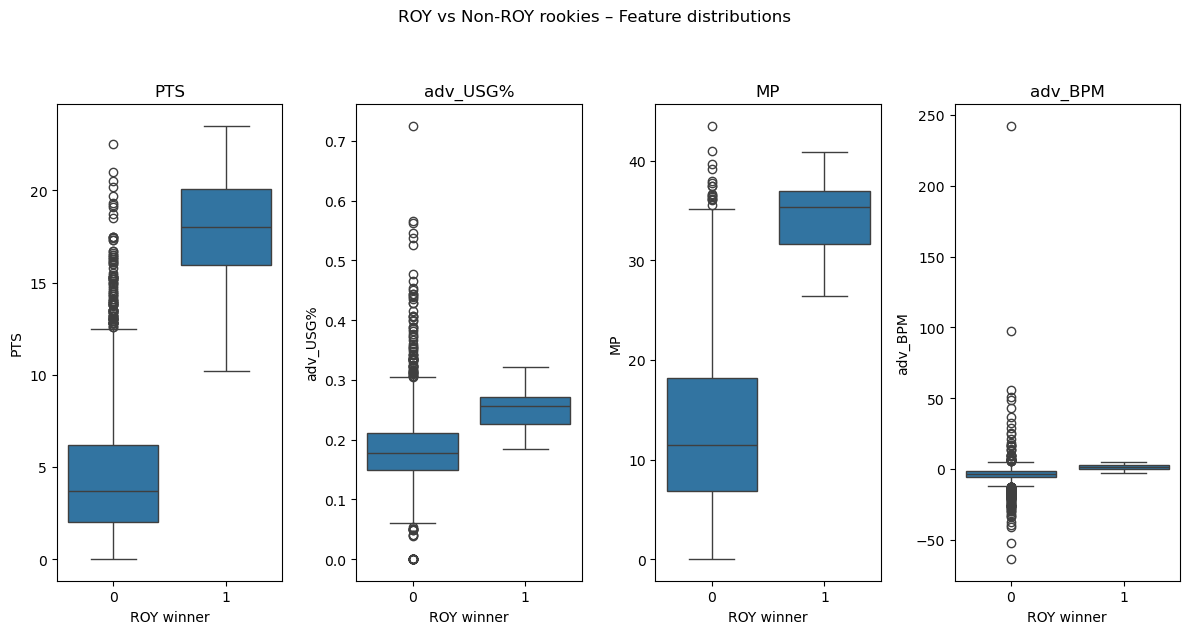

In [13]:
# --- ROY winner flag ---
df["is_roy_winner"] = (df["roy_rank"] == 1).fillna(False).astype(int)

# Focus on rookies only
df_rookie = df[df["is_rookie"] == 1]

features = ["PTS", "adv_USG%", "MP", "adv_BPM"]

# Keep only available columns
features = [c for c in features if c in df_rookie.columns]

# --- Boxplots: ROY vs non-ROY ---
plt.figure(figsize=(12, 6))

for i, col in enumerate(features, 1):
    plt.subplot(1, len(features), i)
    sns.boxplot(
        data=df_rookie,
        x="is_roy_winner",
        y=col
    )
    plt.xlabel("ROY winner")
    plt.title(col)

plt.suptitle("ROY vs Non-ROY rookies – Feature distributions", y=1.05)
plt.tight_layout()
plt.show()

### 📊 ROY vs Non-ROY Rookies — Interpretation of the Results

The boxplots highlight **clear and consistent differences** between Rookie of the Year (ROY) winners and other rookies across all examined features.

**Key observations:**

- **Points per game (PTS)**  
  ROY winners score **substantially more points** than the average rookie.  
  The median PTS of ROY winners is roughly **4–5× higher**, confirming that scoring volume is a primary driver of ROY selection.

- **Usage rate (adv_USG%)**  
  ROY winners exhibit a **significantly higher offensive usage**, indicating that they are not only efficient but also entrusted with a central offensive role early in their careers.

- **Minutes played (MP)**  
  ROY winners play **far more minutes**, suggesting that availability, durability, and coaching trust are crucial prerequisites for ROY consideration.

- **Advanced impact (adv_BPM)**  
  While more variable, ROY winners tend to have **consistently positive BPM**, whereas non-ROY rookies show wide dispersion and often negative impact.
  This indicates that ROY voters reward **overall on-court impact**, not just raw scoring.

**Conclusion:**

ROY selection strongly favors rookies who:
- play **heavy minutes**,  
- carry a **high offensive responsibility**,  
- produce **immediate scoring**,  
- and demonstrate **positive advanced impact**.

This mirrors MVP voting logic at a smaller scale:  
**early-career dominance and responsibility matter more than isolated box-score efficiency.**

These results justify using ROY-related signals as informative features in downstream modeling.

### 🛡️ Defensive Player of the Year (DPOY) – Correlation Analysis

This cell explores the relationship between **defensive performance indicators** and DPOY outcomes.

Since a **lower `dpoy_rank` corresponds to a better result** (rank = 1 is the winner),
**negative correlations indicate stronger DPOY signals**.

We focus on defensive box-score statistics (blocks, steals) and advanced defensive impact
metrics (Defensive Win Shares, Defensive RAPTOR) to understand which signals are most
aligned with DPOY voting.


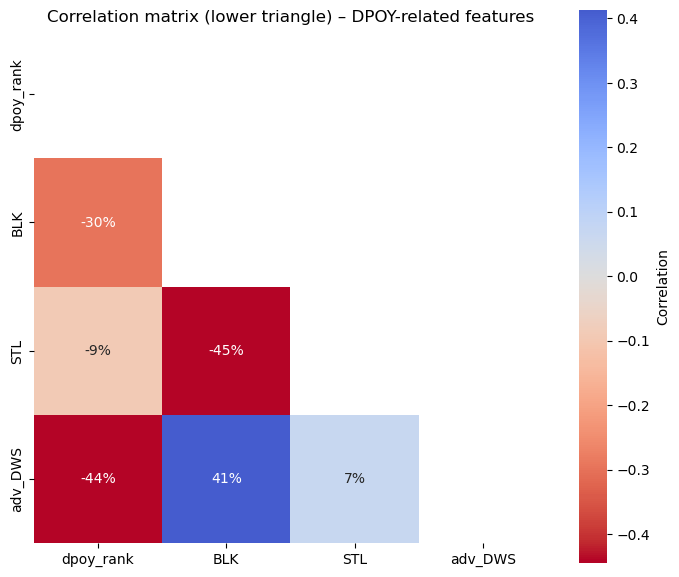

In [14]:
# -----------------------------
# DPOY correlation (lower triangle)
# -----------------------------

cols = [
    "dpoy_rank",
    "BLK",
    "STL",
    "adv_DWS",
    "raptor_def",
]

# Safety: keep only existing columns
cols = [c for c in cols if c in df.columns]

corr = df[cols].dropna().corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm_r",   # inverted: blue = good signal
    center=0,
    annot=True,
    fmt=".0%",
    square=True,
    cbar_kws={"label": "Correlation"}
)

plt.title("Correlation matrix (lower triangle) – DPOY-related features")
plt.tight_layout()
plt.show()


### 🔍 DPOY Correlation Analysis – Interpretation

Lower `dpoy_rank` indicates a better DPOY outcome (rank = 1 is the winner),  
so **negative correlations represent positive signals for DPOY voting**.

Key insights from the correlation matrix:

- **Defensive Win Shares (adv_DWS)** show the **strongest negative correlation** with `dpoy_rank` (≈ −45%).  
  This confirms that **global defensive impact metrics** are the primary drivers of DPOY recognition.

- **Blocks (BLK)** are also meaningfully correlated with DPOY outcomes (≈ −30%),  
  indicating that **rim protection remains a strong but secondary signal**.

- **Steals (STL)** show a much weaker correlation (≈ −9%),  
  suggesting they are **less influential on DPOY voting** when considered alone.

- The moderate positive correlation between **BLK and adv_DWS** highlights some redundancy,  
  but also shows that advanced metrics capture more than raw defensive events.

Overall, this confirms that **DPOY voting prioritizes sustained defensive impact**
over isolated box-score statistics, reinforcing the relevance of advanced defensive metrics
for modeling this award.


### 🧩 Missing Values Analysis

This cell computes the **percentage of missing values per feature** and highlights
columns with more than **20% missing data**.

This step is critical to:
- identify features that are **structurally sparse** (not errors),
- guide **feature selection and pruning** before modeling,
- decide which variables require **imputation, masking, or exclusion**.

In [15]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0.2]

all_rookie_team           1.000000
mip_rank                  0.997918
cpoy_rank                 0.997155
roy_rank                  0.985221
all_def_team              0.978906
smoy_rank                 0.971621
mvp_rank                  0.969678
all_nba_team              0.968776
dpoy_rank                 0.967250
shot_Awards               0.883916
adv_Awards                0.880724
p100_Awards               0.880724
p36_Awards                0.880724
adj_Awards                0.880724
tot_Awards                0.880724
mamba__D-MAMBA            0.682279
mamba__MAMBA_rank         0.682279
mamba__MAMBA              0.682279
mamba__D-MAMBA_rank       0.682279
mamba__O-MAMBA            0.682279
mamba__Minutes            0.682279
mamba__player_name        0.682279
mamba__nba_id             0.682279
mamba__O-MAMBA_rank       0.682279
lebron__Season            0.475437
lebron__player_name       0.475437
lebron__D-LEBRON          0.475437
lebron__nba_id            0.475437
lebron__D_LEBRON_Ran

#### Key takeaways:

- **Award-related ranks and selections** (`mvp_rank`, `dpoy_rank`, `smoy_rank`, `all_nba_team`, etc.)  
  are missing for the vast majority of players.  
  This is expected, as **only a handful of players receive votes or selections each season**.
  These columns should be treated as **target variables or sparse labels**, not standard features.

- **Advanced external metrics (MAMBA, LEBRON, RAPTOR)** show high missing rates (≈45–70%).  
  This reflects **limited temporal coverage** (e.g. metrics only available from ~2010 or later),
  not data quality issues.

- **Awards text-derived columns** (`*_Awards`) are also highly sparse and mostly redundant
  now that structured award indicators and ranks have been extracted.

- A small number of **shooting-related features** (e.g. detailed 3PT splits)
  have moderate missingness, likely due to **low-attempt players or historical data gaps**.

Overall, this analysis confirms that missingness is **systematic and interpretable**.
It motivates:
- dropping raw award text columns,
- keeping sparse award ranks only for supervision,
- handling advanced metrics with **year-aware filtering or model-specific feature subsets**.
